In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import math

In [2]:
# function for numerical scheme in custom package 
from euler_scheme_1d_with_growth.analytical_solutions import steady_solution, nrect
from euler_scheme_1d_with_growth.functions_for_numerics import *

In [3]:
# GROWTH RULE
import euler_scheme_1d_with_growth.two_morph as two_morph
from euler_scheme_1d_with_growth.growth_rules import two_morph_growth_rule as growth_rule

In [4]:
default_figsize = plt.rcParams['figure.figsize']

# Parameters

## Diffusion

In [5]:
# assume to be 1
D     = 1
beta  = 1
alpha = 1
lam   = math.sqrt(D/beta) 

# supported by experiments
x0    = 0.4*lam 
w     = 0.4*lam

# minimal anitial size: minimal possible x0 + w, minimal plausible 2 * (x0 + w/2), minimal prefered (2 * x0 + 2 * w)
L0    = 1.8 * lam

In [6]:
steady_solution( 2.632792792792793/2, x0, lam, alpha, w, beta, D, 2.632792792792793 )

0.13788951200208274

In [7]:
thresholds_to_test = np.linspace(0.13788951200208277, 0.22, 5)
# for plotting
Lfinals = np.linspace(0, 4 , 100)

## Parameters for simulations

In [8]:
small_number = 1e-6

# space x
ndx  = 500
dx   = L0/ndx

# time t
tmax         = 10
dt           = 0.5*1e-5
t            = np.arange(0, tmax+small_number, dt)
ndt          = len(t)

# save only ndt_to_save time points
ndt_to_save = 1000

In [9]:
D * dt / dx**2

0.3858024691358025

# Lfinal(threshold)

In [10]:
thresholds = np.array( [
    two_morph.threshold_vs_Lfinal(Lfinal, x0, lam, alpha, w, beta, D) 
    for Lfinal in Lfinals] )

In [11]:
print( thresholds_to_test )
Lfinals_to_reach   = np.array([
    two_morph.Lfinal(threshold, x0, lam, alpha, w, beta, D) for threshold in thresholds_to_test
])

[0.13788951 0.15841713 0.17894476 0.19947238 0.22      ]


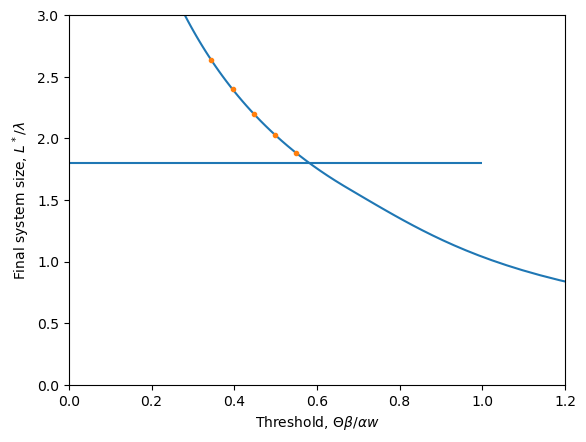

In [12]:
plt.plot( thresholds*beta/alpha/w, Lfinals/lam )
plt.plot( thresholds_to_test*beta/alpha/w, Lfinals_to_reach/lam, '.' )
plt.hlines(L0, 0, 1)
plt.xlabel(r'Threshold, $\Theta \beta / \alpha w$')
plt.ylabel(r'Final system size, $L^*/\lambda$')
plt.xlim( 0, 1.2 )
plt.ylim( 0, 3 )
plt.show()

## Chosen growth rate, threshold

In [13]:
g_to_test = np.array([0.5, 1, 2]) * beta

In [14]:
g = g_to_test[0]
threshold_growth = thresholds_to_test[0]

In [15]:
g

0.5

In [16]:
threshold_growth

0.13788951200208277

# Simulation

In [17]:
from euler_scheme_1d_with_growth.two_morph import *

In [18]:
threshold_growth = thresholds_to_test[0]

In [19]:
print(f'th_{threshold_growth}_g_{g}')
simulation = two_morph_euler_steady(D, beta, alpha, L0, x0, w, g, threshold_growth, ndx, dx, tmax, dt, t, ndt, ndt_to_save)
simulation.run_simulation()

th_0.13788951200208277_g_0.5


100%|██████████████████████████████| 2000000/2000000 [02:18<00:00, 14465.55it/s]


In [20]:
time_to_save = simulation.time_to_save
Lt = simulation.Lt

x_centerst = simulation.x_centerst
x_gridt = simulation.x_gridt

s_steadyt = simulation.s_steadyt
f_steadyt = simulation.f_steadyt

#st = simulation.st
#ft = simulation.ft

source_st = simulation.source_st
source_ft = simulation.source_ft

grt = simulation.grt

grsizet = simulation.grsizet

# Plot results

## System size

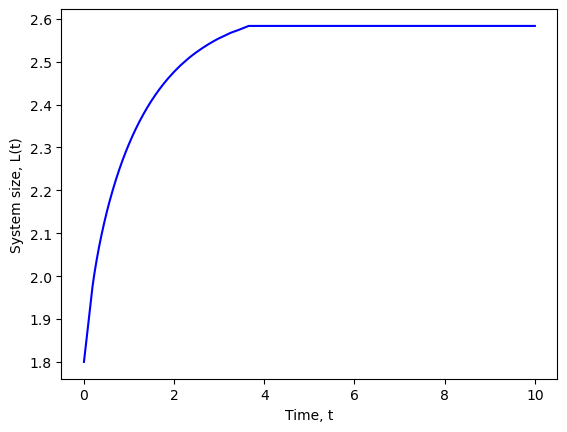

In [21]:
plt.plot( time_to_save, Lt, 'b')
#plt.ylim(0, 2*L0)
plt.xlabel('Time, t')
plt.ylabel('System size, L(t)')
plt.show()

## Relative growth region size

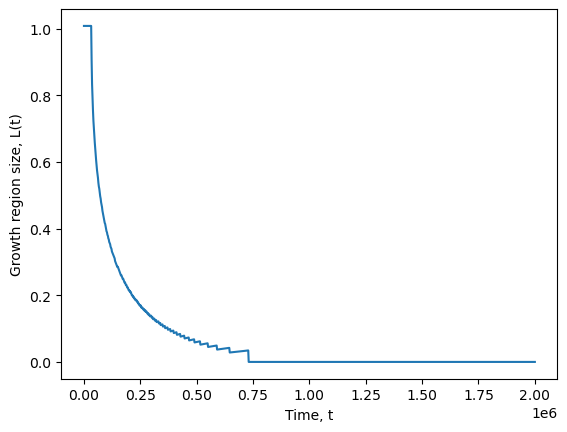

In [22]:
plt.plot(np.linspace(1, ndt, ndt_to_save).astype(int), grsizet / Lt)
#plt.ylim(0, 1)
plt.xlabel('Time, t')
plt.ylabel('Growth region size, L(t)')
plt.show()

## Morphogen gradient profiles for three picked time points

- t0: gap between sources is ~w
- t1: the relative growth region is ~1/2 of the relative growth region at t0
- t2: growth has stopped

In [23]:
from matplotlib_defaults import *

### Picking these time points

In [24]:
def plot_concentration(ax, n, i):
    ax.fill_between(x_centerst[n], source_st[n], color="red", alpha=0.5)
    ax.fill_between(x_centerst[n], source_ft[n], color="blue", alpha=0.5)
    ax.fill_between(x_centerst[n], threshold_growth * grt[n], color="green", alpha=0.5)
#    ax.plot(x_centerst[n], st[n], 'r', label='Source term (st)')
#    ax.plot(x_centerst[n], ft[n], 'b', label='Source term (ft)')
    ax.plot(x_centerst[n], s_steadyt[n], 'r', label='Steady state (st)')
    ax.plot(x_centerst[n], f_steadyt[n], 'b', label='Steady state (ft)')
    ax.set_title(f't = {round(time_to_save[n], 2)}')
    ax.set_xlabel('Position, x')
    ax.set_ylabel('Concentration, c(x)')
    ax.set_ylim(0, 0.4)

In [25]:
def mask_middle_zeros(arr):
    
    if not isinstance(arr, np.ndarray):
        arr = np.array(arr)
    
    # Identify the indices where transitions between 0 and 1 occur
    boundaries = np.where(np.diff(np.concatenate(([1], arr, [1]))))[0]
    
    # Find the groups of zeros
    zero_groups = [
        (start, end)
        for start, end in zip(boundaries[:-1], boundaries[1:])
        if arr[start:end].all() == 0
    ]
    
    if len(zero_groups) < 1:
        raise ValueError("The array does not contain a middle group of zeros.")
    
    # Select the middle group of zeros
    if len(zero_groups) != 1:
        mid_group = zero_groups[len(zero_groups) // 2]
    else:
        mid_group = zero_groups[0]

    # Create the mask
    mask = np.zeros_like(arr, dtype=bool)
    mask[mid_group[0]:mid_group[1]] = True

    return mask

In [26]:
gaps = []
for n in range(0, len(time_to_save)):
    if 2 not in source_st[n] + source_ft[n]: # no overlap between sources
        gap_mask = mask_middle_zeros(source_st[n] + source_ft[n])
        
        gaps.append( 
            float( np.sum( gap_mask * x_gridt[n] ) )
        )
    else:
        gaps.append( np.nan )
gaps = np.array( gaps )

In [27]:
def find_closest_index(array, value):
    array = np.array(array)  # Ensure input is a numpy array
    # Mask NaN values
    valid_mask = ~np.isnan(array)
    valid_array = array[valid_mask]
    
    if valid_array.size == 0:
        raise ValueError("The array contains only NaN values.")
    
    # Find the index of the closest value in the valid array
    closest_index_in_valid = np.argmin(np.abs(valid_array - value))
    
    # Map back to the original array index
    original_index = np.where(valid_mask)[0][closest_index_in_valid]
    
    return int(original_index)

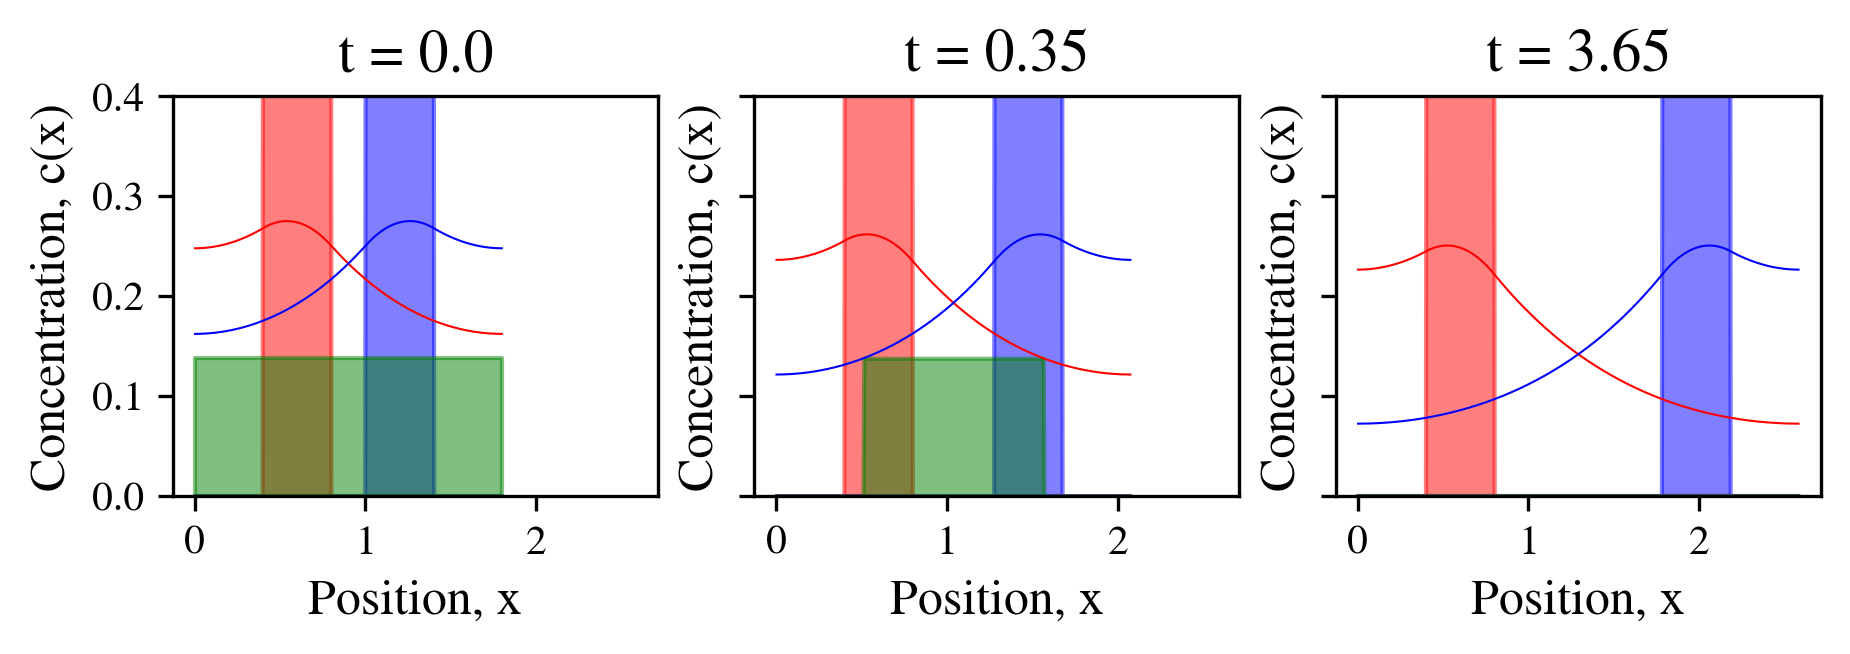

In [28]:
nrows, ncols = 1, 3
fig, ax = plt.subplots(nrows, ncols, figsize=(default_figsize["large"][0], default_figsize["large"][1]/5), sharex=True, sharey=True)
t_to_plot = np.arange(0, tmax+small_number, tmax/nrows)

i = 1
ax = plt.subplot(nrows, ncols, i)
# t0: the last moment then growth is in the whole system
#if len( np.argwhere( np.round( grsizet / Lt, 1 ) == 1) ) == 0:
#    nt0 = 0
#else:
#    nt0 = np.argwhere( np.round( grsizet / Lt, 1 ) == 1)[-1][0]
nt0 = 0

plot_concentration(ax, nt0, i)

i = 2
ax = plt.subplot(nrows, ncols, i)
# t1: the relative growth region is ~1/2 of the relative growth region at t0
nt1 = find_closest_index( (grsizet / Lt) / (grsizet / Lt)[nt0], 0.5 )
plot_concentration(ax, nt1, i)

i = 3
ax = plt.subplot(nrows, ncols, i)
# t2: growth has stopped
if len(np.argwhere( grsizet == 0 )) == 0:
    nt2 = len(grsizet)-1
else:
    nt2 = np.where( grsizet == 0 )[0][0]
    
plot_concentration(ax, nt2, i)

plt.savefig('fig/two_morph_profiles_t0_t1_t2_steady.pdf', bbox_inches='tight')

plt.show()

## Cartoons

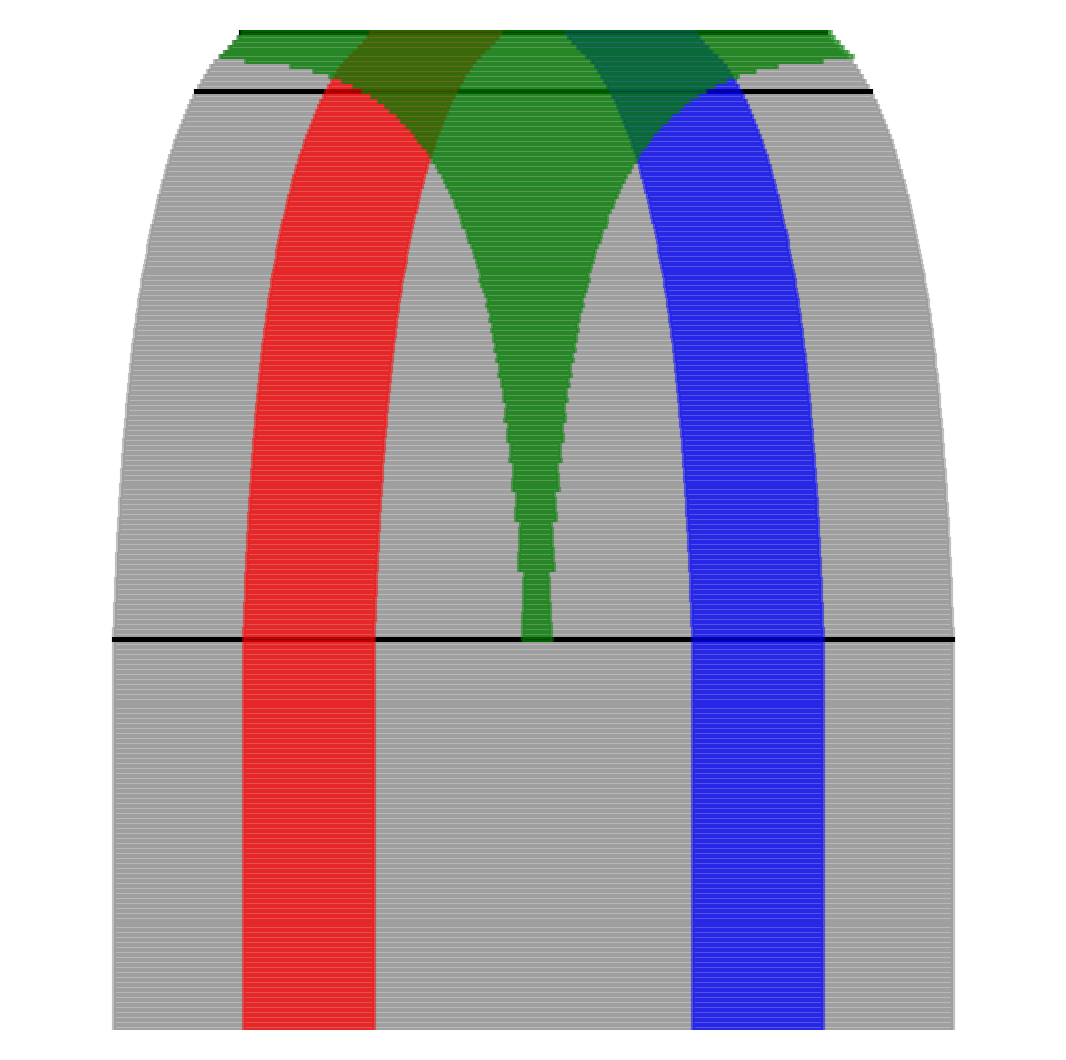

In [29]:
nrows, ncols = 201, 1
fig, ax = plt.subplots(nrows, ncols, figsize=(default_figsize["medium"][0], default_figsize["medium"][0]), sharex=True, sharey=True, gridspec_kw={'hspace': 0})
#t_to_plot = np.arange(0, time_to_save[nt2+50] + small_number, time_to_save[nt2+50]/nrows)
t_to_plot = np.arange(0, 0.6*tmax+small_number, 0.6*tmax/nrows)

# characteristic time points
n_to_plot = []
for i in range(1, ncols*nrows+1):
    n = int(t_to_plot[i - 1] / dt / (ndt / ndt_to_save))
    n_to_plot.append( n )

nt = [ 
    n_to_plot[find_closest_index( n_to_plot, nt0 )], 
    n_to_plot[find_closest_index( n_to_plot, nt1 )], 
    n_to_plot[find_closest_index( n_to_plot, nt2 )] 
]

middle = 0
for i in range(1, ncols*nrows+1):
    ax = plt.subplot(nrows, ncols, i)
    n = int(t_to_plot[i - 1] / dt / (ndt / ndt_to_save))
    
    # shift to maintain the growth zone middle at the same position        
    if grsizet[n] != 0:
        x0gr = x_centerst[n][ np.nonzero( grt[n] )[0][0] ]  # Center position of the green rectangle
        x_start = middle - Lt[n]/2

    if n in nt:
        ax.add_patch(plt.Rectangle( (x_start, 0), Lt[n], 1, color='black' ))
    else:
        ax.add_patch(plt.Rectangle( (x_start, 0), Lt[n], 1, color='gray', alpha=0.5))
        
    ax.add_patch(plt.Rectangle( (x_start+x0, 0),         w,     1, color='red',  alpha=0.5))
    ax.add_patch(plt.Rectangle( (x_start+Lt[n]-w-x0, 0), w,     1, color='blue', alpha=0.5))

    if grsizet[n] != 0:
        x0gr = x_centerst[n][ np.nonzero( grt[n] )[0][0] ]
        ax.add_patch(plt.Rectangle((x_start + x0gr, 0), grsizet[n], 1, color='green', alpha=0.5))

    ax.set_xlim(-0.6*max(Lt), 0.6*max(Lt))
    ax.set_axis_off()
    
plt.savefig('fig/two_morph_kymograph_steady.pdf', bbox_inches='tight')

plt.show()

# System size (threshold)

In [30]:
thresholds = np.array( [
    two_morph.threshold_vs_Lfinal(Lfinal, x0, lam, alpha, w, beta, D) 
    for Lfinal in Lfinals] )

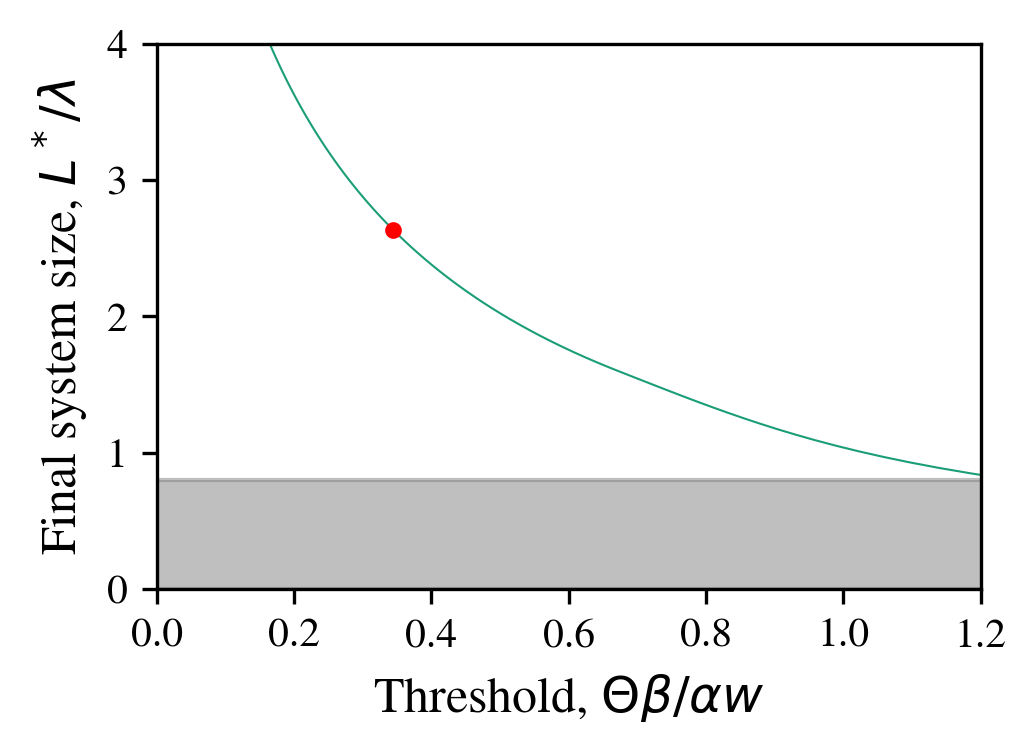

In [31]:
fig = plt.figure(figsize = default_figsize['small'])
ax = plt.subplot()

ax.plot( thresholds*beta/alpha/w, Lfinals/lam )
ax.plot( threshold_growth*beta/alpha/w,  two_morph.Lfinal(threshold_growth, x0, lam, alpha, w, beta, D)/lam, 'r.')

ax.fill_between( np.linspace(0, 2), 0, x0 + w, color='gray', alpha=0.5)
    
ax.set_xlabel(r'Threshold, $\Theta \beta / \alpha w$')
ax.set_ylabel(r'Final system size, $L^*/\lambda$')
plt.xlim( 0, 1.2 )
plt.ylim( 0, 4 )

plt.savefig('fig/two_morph_Lfinal_steady.pdf', bbox_inches='tight')

plt.show()

# Sensitivity to parameters

In [32]:
parms = {'theta': threshold_growth, 'D': D,'beta': beta, 'x0': x0, 'w': w, 'alpha': alpha}

parms_rows = { 
    0: {'theta': threshold_growth, 'D': D, 'beta': beta},
    1: {'x0':    x0,               'w': w, 'alpha': alpha}
}

Lfinal_ref = two_morph.Lfinal(threshold_growth, x0, lam, alpha, w, beta, D)

In [33]:
pc = 0.2 # percentage to variate a parameter

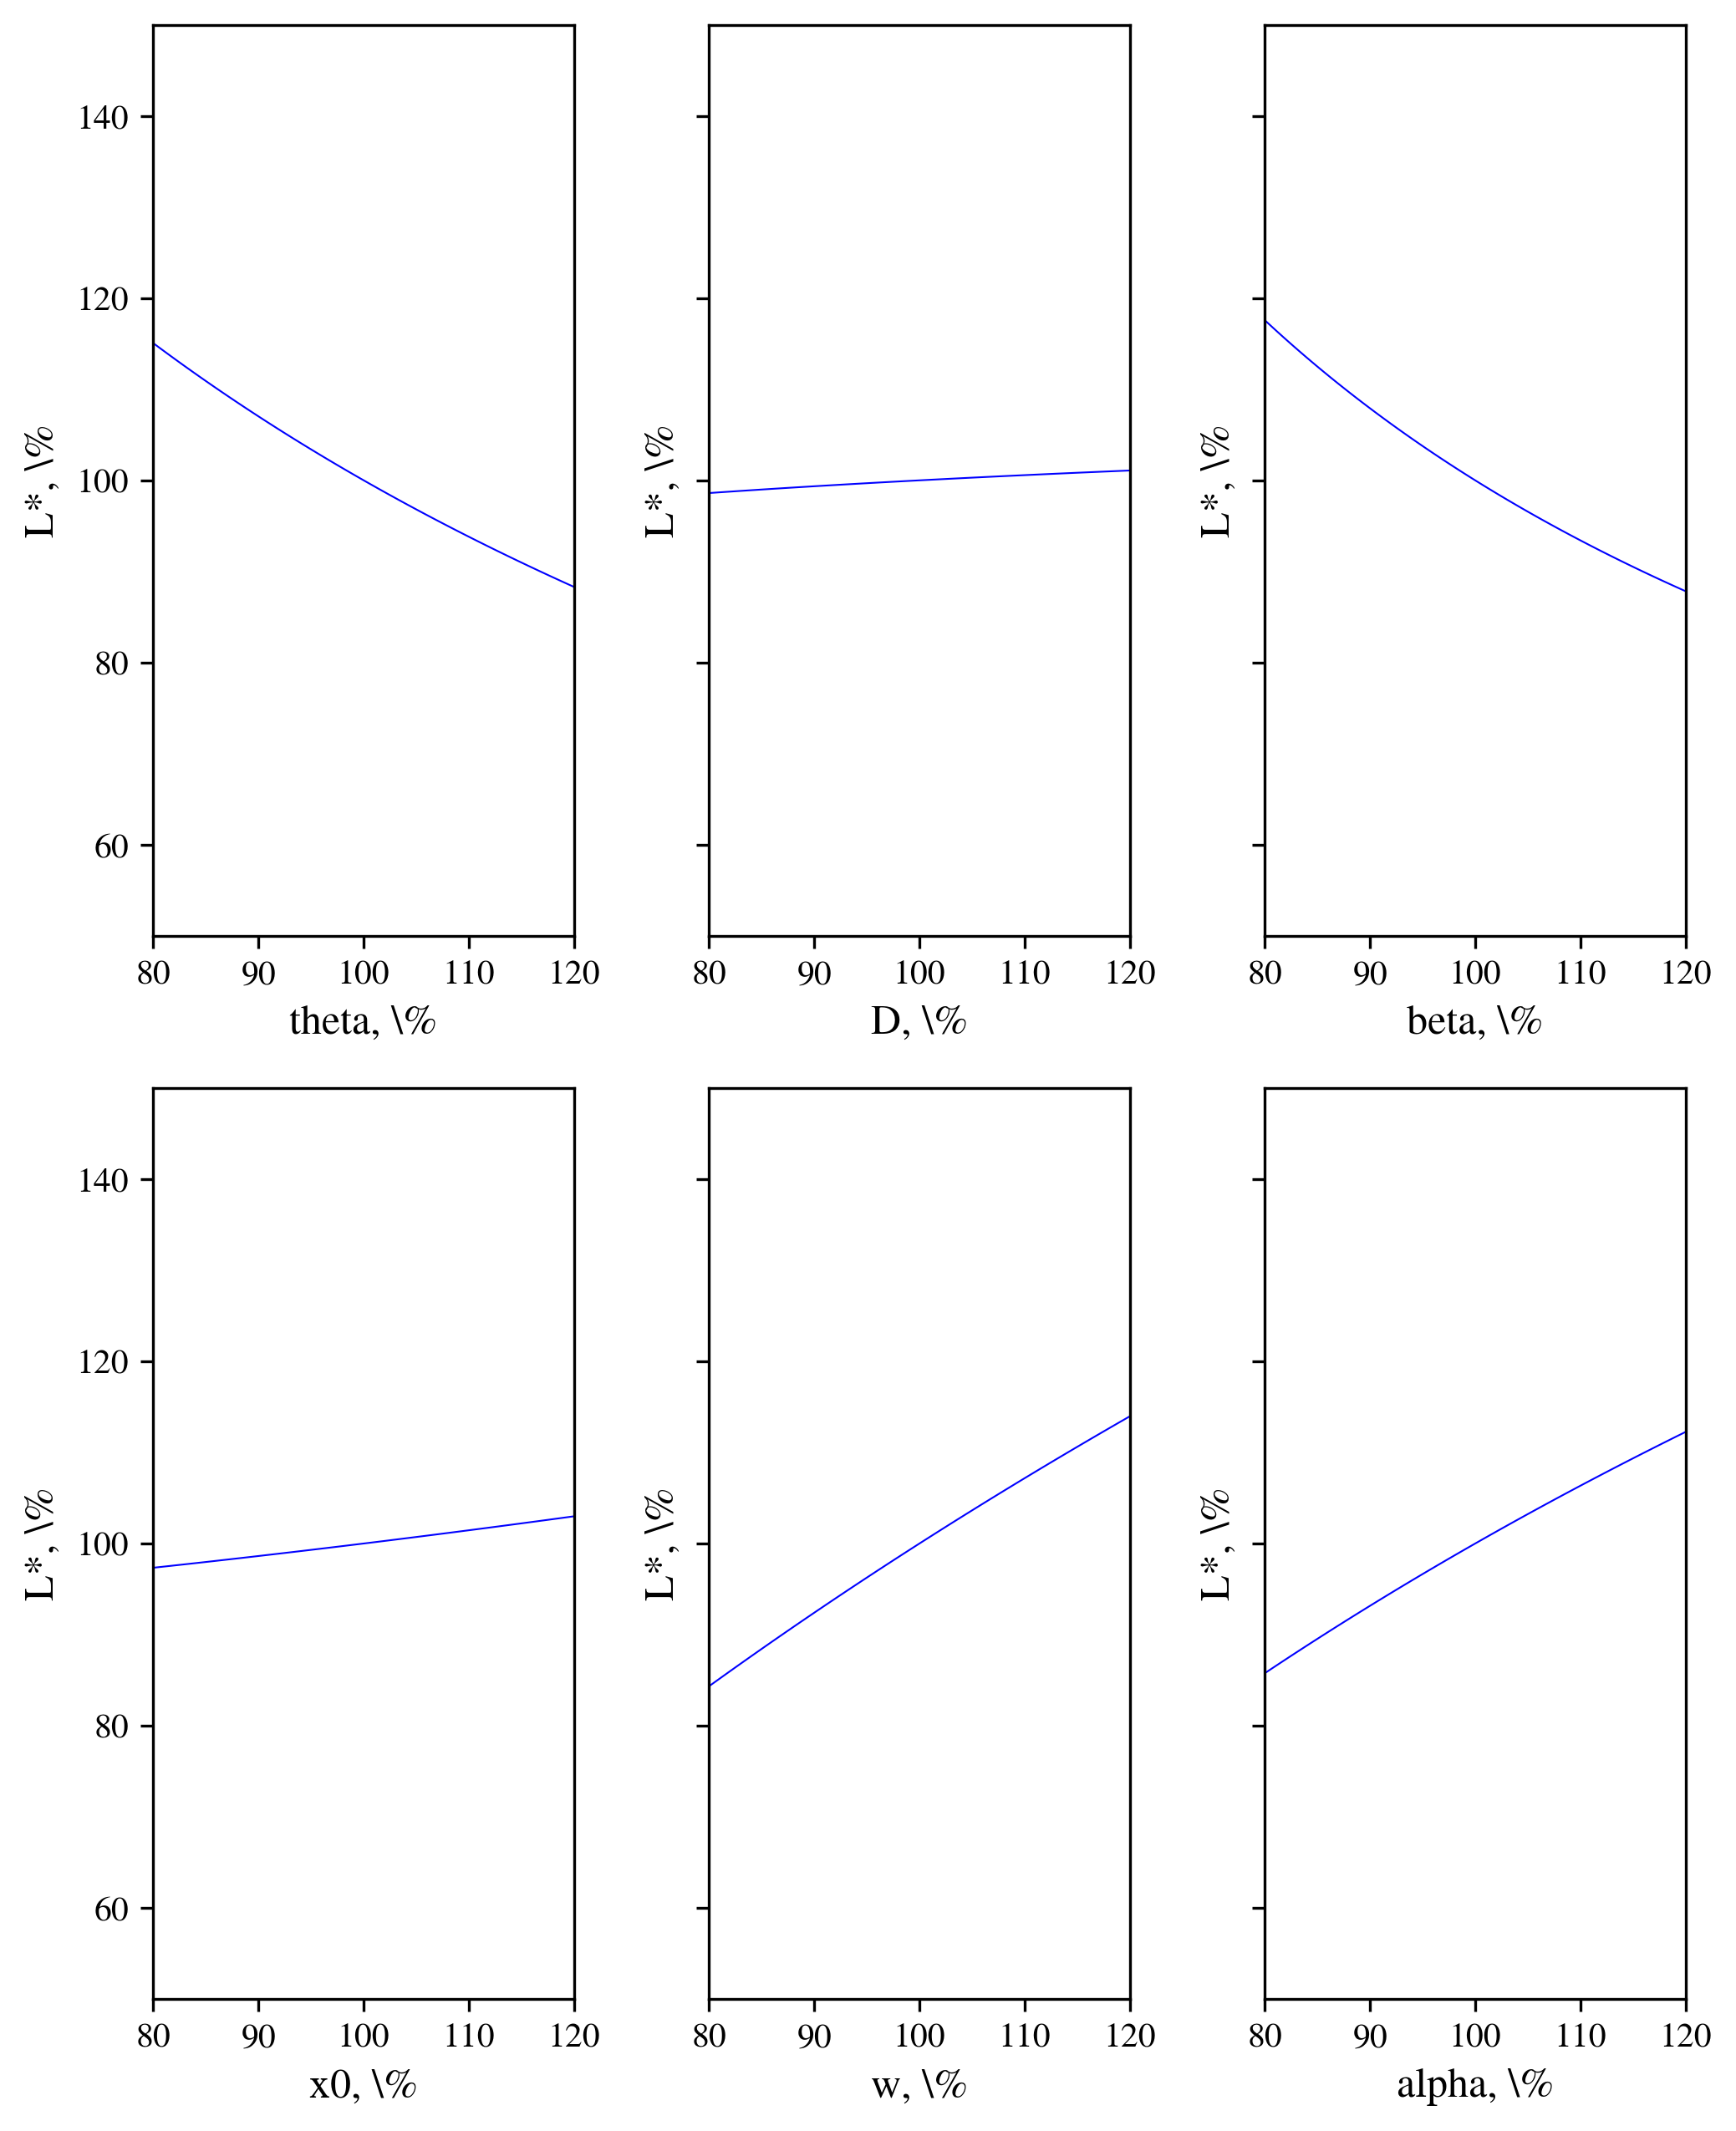

In [34]:
nrows, ncols = 2, 3
fig, ax = plt.subplots(nrows, ncols, figsize=(default_figsize["large"][0], default_figsize["large"][1]) , sharex=False, sharey=True)

for i in parms_rows.keys():
    for j, parm_name in enumerate(parms_rows[i]):
        xparm = np.linspace(
            (1 - pc) * parms[parm_name], 
            (1 + pc) * parms[parm_name], 
            100
        )

        yLfinal = []
        for value in xparm:
            temp_parms = parms.copy()
            temp_parms[parm_name] = value  
            yLfinal.append(
                 two_morph.Lfinal(
                    temp_parms['theta'], 
                    temp_parms['x0'], 
                    np.sqrt( temp_parms['D']/temp_parms['beta'] ),
                    temp_parms['alpha'], 
                    temp_parms['w'], 
                    temp_parms['beta'], 
                    temp_parms['D']
                 )
            )
        xparm   = 100 * xparm / parms[parm_name]
        yLfinal = 100 * np.array( yLfinal ) / Lfinal_ref

        ax[i, j].plot( xparm, yLfinal, 'b' )
        ax[i, j].set_xlabel( parm_name + ', \%')
        ax[i, j].set_ylabel( 'L*, \%' )
        ax[i, j].set_xlim( int((1 - pc) * 100), int((1 + pc) * 100) )
        ax[i, j].set_ylim( 50, 150 )
        
plt.savefig('fig/two_morph_sensitivity_to_parm_steady.pdf', bbox_inches='tight')

plt.tight_layout()
plt.show()